<a href="https://colab.research.google.com/github/ialara/or-student/blob/main/lectures/Artificial_Societies_TA_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The *classic* libraries 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import time
import copy
import math
import random
%matplotlib inline
# Some plotting aesthetics
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-dark')

_Provided/reference code_

In [ ]:
# Re-usable code to obtain values for different kinds of plots.
def run_simultaneous_iterations(step_fn, n=100, x0=0, **params):
  """Iterate f(x; a) n times for separate values of parameters a.

  Arguments:
  step_fn -- callable representing one step. Must be of the form 
             step_fn(x, **params), and return an 1-d array of scalars equal in 
             length to the length of each parameter list.

  Keyword arguments:
  n -- int for the number of iterations to perform.
  x0 -- int or float for the initial condition (value of x for n=0)
  params -- one or more lists of parameter spaces to explore.

  Returns: tuple of lists for (label, data). label is a str that contains the
           parameter values corresponding to the n-array data for that run.   
  """

  # Runs n iterations for a given 'case' (set of parameter values)
  def do_n_iterations(step_fn, param_dict):
      if isinstance(x0, tuple):
        vars = len(x0)
        vals = np.empty((n+1, vars, num_cases))
        vals[0] = np.broadcast_to(x0, (num_cases, vars)).T
        for i in range(1, n+1):
          vals[i] = step_fn(*vals[i-1], **param_dict)
      else:
        vals = np.empty((n+1, num_cases))
        vals[0] = x0
        for i in range(1, n+1):
          vals[i] = step_fn(vals[i-1], **param_dict)
      return np.transpose(vals)

  # If user provides a single case, convert to a list of dim 1 (allows code
  # to accept either a single value or list of values per parameter)
  params = {k: [v] if not isinstance(v, list) else v for k, v in params.items()}
  
  # Make sure each parameter has the same number of values to try.
  shape_list = [len(v) for v in params.values()]
  if not shape_list.count(shape_list[0]) == len(shape_list):
    raise ValueError('Parameter lists must be of same length.')

  num_cases = shape_list[0]
  
  # Transform a dict of lists like {'a': [a1, a2, a3], 'b': [b1, b2, b3]} to 
  # a list of dicts representing distinct cases of parameter values: 
  # [{'a': a1, 'b': b1}, {'a': a2, 'b': b2}]
  cases = [dict(zip(params.keys(), i)) for i in zip(*params.values())]
  labels = [str(case) for case in cases]

  # Collects results for each case of parameter values.
  data = do_n_iterations(step_fn, params)

  return labels, data

def make_iteration_plot(data, ax=None, plot_title='Iteration Plot', **kwargs):
  """Plot x_(n+1) = f(x_n; a) vs. n for multiple parameter values a.
  
  Arguments:
  data -- a tuple of the form (labels, arr) containing the results of iterating
          a function multiple times for different parameter values.

  Keyword arguments:
  plot_title -- str to use as plot title. (default 'Iteration Plot')
  ax -- the Axes to plot on. If None, will use current Axes.
  kwargs -- other keyword arguments (Not Implemented.)

  Returns: ax. The Axes object.
  """

  labels, outputs = data

  if ax is None:
    ax = plt.gca()

  ns = range(n+1)
  for case in range(len(outputs)):
    ax.plot(ns, outputs[case], label = labels[case], lw=0.6)

  ax.set_xlabel('n')
  ax.set_ylabel(r'$x^{(n)}$')
  ax.set_title(plot_title)
  
  return ax

def make_return_plot(data, ax=None, plot_title='Return Plot', fmt='.',
                     labels=None, **kwargs):
  """Plot x_(n+1) = f(x_(n); a) vs. x_(n) for multiple parameter values a.
  
  Arguments:
  data -- a tuple of the form (labels, arr) containing the results of iterating
          a function multiple times for different parameter values.

  Keyword arguments:
  plot_title -- str to use as plot title. (default 'Return Plot')
  ax -- the Axes to plot on. If None, will use current Axes.
  fmt -- str to format the marker style in the plot. (default simple 'dots')
  labels -- list containing names of variables if iterating a system >1.
  kwargs -- other keyword arguments (Not Implemented.)

  Returns: ax. The Axes object.
  """
  
  # Collects results for each case of parameter values.
  labs, output = data
  #print(data.shape, data[0])
  
  if ax is None:
    ax = plt.gca()
  
  if labels:
    labs *= len(labels)
    labs = [var + ', ' + case for var, case in zip(labels, labs)]

  for case in range(len(output)):
    if output.ndim > 2: # System of equations (multiple variables)
      for var in range(len(output[case])):
        ax.plot(output[case, var, :-1], output[case, var, 1:], fmt,
              markersize=1, label=labs[var], alpha=1)
    else:
      ax.plot(output[case, :-1], output[case, 1:], fmt,
              markersize=1, label=labs[case], alpha=1)

  ax.set_xlabel(r'$x^{(n)}$')
  ax.set_ylabel(r'$x^{(n+1)}$')
  ax.set_title(plot_title)

  return ax

def make_phase_plot(data, ax=None, plot_title='Phase Plot', fmt=',', labels=None,
                    **kwargs):
  """Plot y vs. x for iterations of a system of equations.
  
  Arguments:
  data -- a tuple of the form (labels, arr) containing the results of iterating
          a function multiple times for different parameter values.

  Keyword arguments:
  plot_title -- str to use as plot title. (default 'Phase Plot')
  ax -- the Axes to plot on. If None, will use current Axes.
  fmt -- str to format the marker style in the plot. (default simple 'dots')
  labels -- list containing names of variables if iterating a system >1.
  kwargs -- other keyword arguments (Not Implemented.)

  Returns: ax. The Axes object.
  """

  labs, output = data

  output = output[0]

  if ax is None:
    ax = plt.gca()

  if labels is None:
    labels = ['x', 'y']
  
  ax.plot(output[0], output[1], fmt, alpha=0.05)
  ax.set_xlabel(labels[0])
  ax.set_ylabel(labels[1])
  ax.set_title(labs[0])

  return ax

def fig_format(fig):
  fig.legend()
  plt.show()

def my_exc_handler(e: Exception):
    print(type(e).__name__, ':', e)

### Problem 2 - Rabbits & Foxes
This problem demonstrates a variety of chaotic outcomes. Consider an ecosystem with rabbits and foxes.  The fraction of the maximum number of rabbits in generation $n+1$ is based on the fraction of the maximum number of rabbits $r_n$ and foxes $f_n$ in the previous generation $n$, is given by:
$$
r_{n+1}=ar_{n}(1-r_n -f_n)
$$

Since $r_n$  and $f_n$ are fractions, $0\leq r_n \leq 1$ and $0≤f_n≤1$. The constant $a$ is the rabbits’ birth rate. For example, if $a=3$, then each rabbit produces 3 offspring in the next generation. The factor $(1-r_n-f_n )$ accounts for deaths due to starvation and predation. If the number of rabbits is low (meaning than $r_n$  is near 0), then few will die of starvation, if it’s high (meaning than $r_n$  is near 1) then many will. Likewise, if the number of foxes is low, few rabbits will be “eaten” and if it is high, many rabbits will die from being eaten.

The number of foxes in the next generation is given by:
$$f_{n+1}=br_n f_n$$

One way you can interpret this is that the chances that a fox encounters and eats a rabbit is $r_n$. So, if the rabbit population is at 80% of its theoretical maximum, 80% of foxes will eat enough to reproduce, and will produce b offspring.

Create a simulation for $r_n$ and $f_n$ for the values of $a$ and $b$ below. Use $r_0=0.25$ and $f_n=0.25$. Iterate 100,000 times.

Create a return map for the rabbits and the foxes with a = 2, b = 3. Connect the dots so it will be easier to see the convergence.



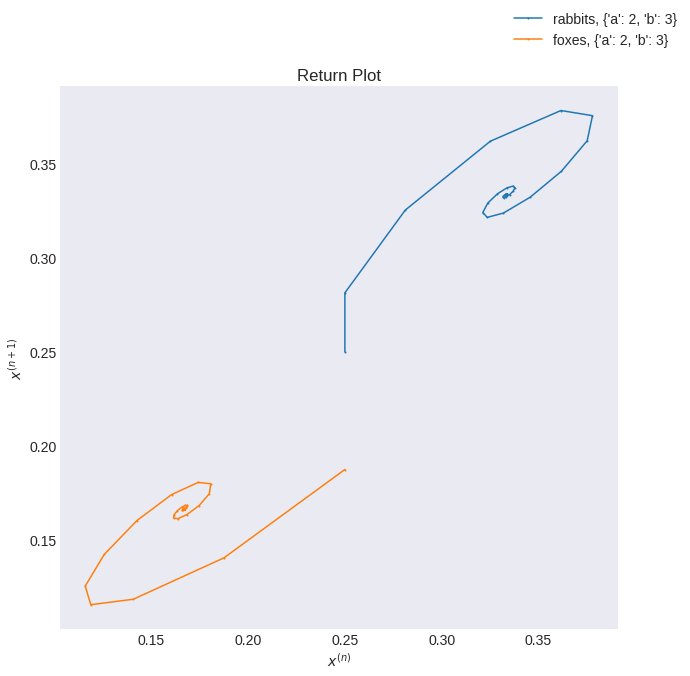

In [ ]:
# Code here
def eco_step(r, f, a, b):
  """Takes one step in the ecosystem of rabbits and foxes.

  Arguments:
  r -- float for fraction of rabbits relative to theoretical maximum.
  f -- float for fraction of foxes relative to theoretical maximum.
  a -- int or float for birth rate of rabbits.
  b -- int or float for birth rate of foxes.

  Returns: tuple (rabbits, foxes) representing the fractional population.
  """

  rabbits = a*r*(1-r-f)
  foxes = b*r*f
  return rabbits, foxes

a_vals = 2
b_vals = 3
x0 = (0.25, 0.25)
n = 100000  


# Provided
fig, ax = plt.subplots()
data = run_simultaneous_iterations(eco_step, n=n, x0=x0, a=a_vals, b=b_vals)

ax = make_return_plot(data, ax=ax, fmt='-o', labels=['rabbits', 'foxes'])
fig_format(fig)

Create a sequence of phase maps between the rabbits and foxes with the following values of a and b. Just use the dots in the plot.
-	a=2.90000, b=3.20000
-	a=3.15333, b=3.44286
-	a=3.08143, b=3.66334
-	a=3.13276, b=3.66883
-	a=3.20667, b=3.50
-	a=3.11376, b=3.88351
-	a=3.41262, b=3.66031

In [ ]:
a_vals = [2.9, 3.15333, 3.08143, 3.13276, 3.20667, 3.11376, 3.41262]
b_vals = [3.2, 3.44286, 3.66334, 3.66883, 3.5, 3.88351, 3.66031]

# Provided
for a, b in zip(a_vals, b_vals):
  data = run_simultaneous_iterations(eco_step, n=n, x0=x0, a=a, b=b)
  fig, ax = plt.subplots()
  ax = make_phase_plot(data, ax=ax, labels=['rabbits','foxes'])


### Problem 4 - Artifical Societies (Neighbors)
Consider another street on which 100 families live. On this street, neighbors are happy unless 
 1.	They were angry last time, but both of their neighbors were happy,
 2.	Exactly one of their neighbors were angry last time, but not them,
 3.	Both of their neighbors were angry last time, but not them,
 4.	They and both of their neighbor were angry last time. \\

If any of the condition 1) – 4) occurred last time, then they are angry.  Create and supply a 2-dimensional time history of these neighbors if only neighbor 50 starts out angry.


Setup: The "society" is a single, circular street of 100 houses. Each house $x$ has the choice to be either "**mean**" or "**nice**" at each time period $t$. 

For time $t > 0$, the choice for each house $x$ to be either "**mean**" or "**nice**" is based on the mean/nice state at time $t-1$ of the house $x$, as well as its immediate neighbors (house $x-1$ and house $x+1$). The mean/nice state for each house at time $t=0$ is set as an initial condition.

#### Linear Automaton Rules
How the houses respond to the previous state is defined by a rule set as follows:
* Let 1 denote "mean" and 0 denote "nice"
* At each time period, there are 8 possible permutations of mean/nice for each set of three houses \[$x-1, \: x, \:  x+1$\]:
    * [0, 0, 0] (all nice)
    * [0, 0, 1]
    * [0, 1, 0]
    * [0, 1, 1]
    * [1, 0, 0]
    * [1, 0, 1]
    * [1, 1, 0]
    * [1, 1, 1] (all mean)
* For $x=1$ and $x=100$, their "neighbors" wrap around. So the left neighbor for $x_1$ is $x_{100}$; the right neighbor for $x_{100}$ is $x_1$.

The rule is defined by a binary representation of these 8 possibilities, i.e. each mean/nice state corresponds to a binary "place." Then, the mean/nice states which result in choosing to be **mean** for the next time period are summed up. 

| Binary place | 128 | 64 | 32 | 16 | 8 | 4 | 2 | 1 |
| ------------ | --- | -- | -- | -- | - | - | - | - |
| Mean/nice state | [1, 1, 1] | [1, 1, 0] | [1, 0, 1] | [1, 0, 0] | [0, 1, 1] | [0, 1, 0] | [0, 0, 1] | [0, 0, 0] |
| $x$ choose mean? | ? | ? | ? | ? | ? | ? | ? | ? |

If a house always chose to be nice, regardless of the preceding mean/nice state, then the sum would be 0 and the house would be playing with **Rule 0**; if the house always chose to be mean, then the sum would be 255 (128 + 64 + 32 + 16 + 8 + 4 + 2 + 1), and the house would be playing with **Rule 255**.

<hr /><br />

Here are some other rules to check your understanding:
* Rule 126. Choose mean if **exactly one or two of our three houses were mean**, otherwise choose nice.

| Binary place | 128 | 64 | 32 | 16 | 8 | 4 | 2 | 1 |
| ------------ | --- | -- | -- | -- | - | - | - | - |
| Mean/nice state | [1, 1, 1] | **[1, 1, 0]** | **[1, 0, 1]** | **[1, 0, 0]** | **[0, 1, 1]** | **[0, 1, 0]** | **[0, 0, 1]** | [0, 0, 0] |
| $x$ choose mean? | 0 | **1** | **1** | **1** | **1** | **1** | **1** | 0 |

* Rule 94. Choose mean if **a) exactly one of our three houses was mean last time; or b) I _and_ exactly one of my neighbors were mean last time**... otherwise choose nice.

| Binary place | 128 | 64 | 32 | 16 | 8 | 4 | 2 | 1 |
| ------------ | --- | -- | -- | -- | - | - | - | - |
| Mean/nice state | [1, 1, 1] | **[1, 1, 0]** | [1, 0, 1] | **[1, 0, 0]** | **[0, 1, 1]** | **[0, 1, 0]** | **[0, 0, 1]** | [0, 0, 0] |
| $x$ choose mean? | 0 | 1 | 0 | 1 | 1 | 1 | 1 | 0 |

* Rule 30. Choose mean if **a) exactly one of our three houses was mean last time; or b) only I and the neighbor to my right were mean last time**...otherwise choose nice.

| Binary place | 128 | 64 | 32 | 16 | 8 | 4 | 2 | 1 |
| ------------ | --- | -- | -- | -- | - | - | - | - |
| Mean/nice state | [1, 1, 1] | [1, 1, 0] | [1, 0, 1] | **[1, 0, 0]** | **[0, 1, 1]** | **[0, 1, 0]** | **[0, 0, 1]** | [0, 0, 0] |
| $x$ choose mean? | 0 | 0 | 0 | 1 | 1 | 1 | 1 | 0 |

_Provided/Reference Code_

In [ ]:
def find_mean_conditions(rule_num: int) -> np.array:
  neighbor_states = np.array([[1, 1, 1], [1, 1, 0], [1, 0, 1],
                     [1, 0, 0], [0, 1, 1], [0, 1, 0],
                     [0, 0, 1], [0, 0, 0]])

  if not isinstance(rule_num, int): raise TypeError("Rule number must be int.")
  if rule_num < 0 or rule_num > 255: raise ValueError("Rule number must be in [0, 255].")

  is_mean_state = [bool(int(bit)) for bit in '{:08b}'.format(rule_num)]

  mean_states = neighbor_states[is_mean_state]

  return mean_states

def choose_mean(prev_state: list, mean_states: list) -> bool:
  return prev_state in mean_states

def Graph(Matrix, ax=None, with_legend=True):
  if ax is None:
    ax = plt.gca(figsize=(8,8)) # Get Current Axis

  cmap = colors.ListedColormap(['blue', 'red'])
  #fig, ax = plt.subplots()
  #plt.imshow(Matrix, cmap=plt.cm.bwr)
  cax = ax.matshow(Matrix, cmap=cmap)
  # cbar = fig.colorbar(cax, ticks=[0, 1])
  # cbar.ax.set_yticklabels(['Nice', 'Mean'])  # vertically oriented colorbar
  patches = [mpatches.Patch(color='blue', label='Nice'),
             mpatches.Patch(color='red', label='Mean')]

  if with_legend: ax.legend(handles=patches, frameon=True)

  return cax
  #plt.show()


# #Input rules
# def ConvertRule(Number):
#     if Number>255:
#         raise ValueError('Number is greater than max allowed (255)')
#     else:
#         String =('{0:08b}'.format(Number))
#         String=[bool(int(Bit)) for Bit in String]
#         return String

def neighbors(rule=126, num_houses=100, num_periods=100, initial_mean=None):
  rule = rule
  num_houses = num_houses
  num_periods = num_periods

  mean_states = find_mean_conditions(rule).tolist()

  if not isinstance(num_houses, int): raise TypeError('num_houses must be int.')
  if not isinstance(num_periods, int): raise TypeError('num_periods must be int.')
  if initial_mean and not isinstance(initial_mean, list):
    raise TypeError('initial_mean must be list of "mean" indices, or None.')

  if num_periods <= 1: raise ValueError('Need at least 2 periods.')
  if num_houses <= 2: raise ValueError('Need at least 3 houses.')

  # Initial conditions
  street = np.zeros((num_periods, num_houses))
  if initial_mean:
    for i in initial_mean:
      if i < 0 or i > num_houses - 1: 
        raise ValueError('Mean indices must be between 0 and {}'.format(num_houses - 1))
      street[0, i] = 1 # Meanie!
  else:
    street[0, int(num_houses/2) - 1] = 1 # Meanie!
  
  # Iterating
  for row in range(1, num_periods):
    prev_row = street[row-1].tolist()
    for house in range(num_houses):
      ## handle edge cases
      if house == 0:
        prev_state = prev_row[-1:] + prev_row[:2] # wrap row to right
      elif house == num_houses-1:
        prev_state = prev_row[-2:] + prev_row[:1] # wrap row to left
      else:   # Non-edge cases
        prev_state = prev_row[house-1:house+2] # Upper limit is not inclusive
      
      #print('({},{}) previous state is: {}'.format(row, house, prev_state))
      street[row, house] = choose_mean(prev_state, mean_states)
  
  fig, ax = plt.subplots(figsize=(8,8))
  Graph(street, ax)
  return ax

In [ ]:
rule = 126
meanies = [49]

# Provided
try:
  ax = neighbors(rule=rule, initial_mean=meanies)
  ax.set_xlabel('House')
  ax.set_ylabel('Iteration')
except Exception as e:
  my_exc_handler(e)

### Problem 5 - Artificial Societies (Nice Town)
Consider a community with 100 parallel streets and 100 families living along each street.  Each family in this community behave according to the following rules:
 1.	If they were happy last time and one or two of their eight neighbors was mean last time, they will be mean this time
 2.	If they were mean last time and 4 or more of their neighbors were mean last time, then they will be mean this time
 3.	Otherwise, they will be happy this time

Begin with everyone happy except:
 1.	Family 30 on street 30
 2.	Family 60 on street 30
 3.	Family 30 on street 60
 4.	Family 60 on street 60 \\

Display the community on a plot with blue representing happy and red representing mean at time periods 1, 10, 20, and 30.

In [ ]:
#Construct is 1 for mad, 0 for happy. 

def NiceTown(Matrix):
    r,c = Matrix.shape #Street and neighbor number (used row column notation for thinking about edge cases)
    r = r-1 #to make it rows-1 for indexing
    c = c-1 #to make it cols-1 for indexing
    TempMat = copy.deepcopy(Matrix) #Creating a new temporary one for preserving the initial "snapshot" in time
    for i in np.arange(r):
        #for every street (rows)
        for j in np.arange(c): #(columns)
            #Create grids for eval. 
            #Perform edge cases (top/bottom, left/right corners)
            if (i==0 and j==0): #First row, first col (wraps up to bottom row, left to end col)
                TopTupple = [Matrix[r, c-1],   Matrix[r, j],   Matrix[r, j+1]  ]
                MidTupple = [Matrix[i, c-1],   Matrix[i, j],   Matrix[i, j+1]  ]
                BotTupple = [Matrix[i+1, c-1], Matrix[i+1, j], Matrix[i+1, j+1] ]
            elif (i==0 and j==c): #First row, end col 
                TopTupple = [Matrix[r, j-1],   Matrix[r, j],   Matrix[r, 0]   ]
                MidTupple = [Matrix[i, j-1],   Matrix[i, j],   Matrix[i, 0]   ]
                BotTupple = [Matrix[i+1, j-1], Matrix[i+1, j], Matrix[i+1, 0] ]
            elif (i==r and j==0): #end row, first col
                TopTupple = [Matrix[r, c-1],   Matrix[i-1, j], Matrix[x, j+1] ]
                MidTupple = [Matrix[i, c-1],   Matrix[i, j],   Matrix[i, j+1] ]
                BotTupple = [Matrix[0, c-1],   Matrix[0, j],   Matrix[0, j+1] ]
            elif (i==r and j==c):#end row, end col
                TopTupple = [Matrix[i-1, j-1], Matrix[i-1, j], Matrix[i-1, 0] ]
                MidTupple = [Matrix[i, j-1],   Matrix[i, j],   Matrix[i, 0]   ]
                BotTupple = [Matrix[0, j-1],   Matrix[0, j],   Matrix[0, 0]   ]
            else:
                TopTupple = [Matrix[i-1, j-1], Matrix[i-1, j], Matrix[i-1, j+1] ]
                MidTupple = [Matrix[i, j-1],   Matrix[i, j],   Matrix[i, j+1]   ]
                BotTupple = [Matrix[i+1, j-1], Matrix[i+1, j], Matrix[i+1, j+1] ]
            #Concatenate:
            EvalGrid = np.vstack((TopTupple,MidTupple,BotTupple)) #Creating a 3x3 grid for evaluation.

            #Now create the rules. From the problem set:
            '''
            R1: If you were nice last time, and one or two of your neighbors was mean last time, you will be mean
            R2: If they were mean last time and 4or more of their neighbors were mean last time, 
            then they will be mean this time.
            Else: Otherwise you will be nice
            '''
            #Rules if statement
            if (EvalGrid[1, 1] == 0 and  (sum(sum(EvalGrid)) == 2 or
                                         sum(sum(EvalGrid)) == 1)):
                TempMat[i, j] = 1 #Become mean. Note with python indexing, 1,1 refers to 2nd row, 2nd col.
            elif (EvalGrid[1, 1] == 1 and  sum(sum(EvalGrid)) >= 5):
                #Stay mean. Needed to include this assignment for the copy though
                #Note that the >=5 comes from the 4 neighbors while also including self. 
                TempMat[i, j] = 1 
            else:
                TempMat[i, j] = 0 #Be nice!
        #End of j for loop
    #End of i for loop
    Matrix = copy.deepcopy(TempMat) #This is the new "snapshot" of the neighborhood
    return Matrix

# def PlotMatrix(Matrix,i, ColorBarInclude):
#   fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
#   if ColorBarInclude:
#     plt.imshow(Matrix, cmap=plt.cm.bwr)
#     cax = ax.imshow(Matrix, cmap=plt.cm.bwr)
#     ax.set_title('Number of iterations:'+str(i))
#     cbar = fig.colorbar(cax, ticks=[0, 1])
#     cbar.ax.set_yticklabels(['Nice', 'Mean']);  # vertically oriented colorbar
#   else:
#     plt.imshow(Matrix, cmap=plt.cm.bwr)
#     ax.set_title('Number of iterations:'+str(i))

In [ ]:
#Initialize matrix and parameters
houses_per_street = 100
streets = 100

Matrix=np.zeros((streets, houses_per_street))
Matrix[29,29] = 1 # Meanie!
Matrix[29,59] = 1 # Meanie!
Matrix[59,29] = 1 # Meanie!
Matrix[59,59] = 1 # Meanie!

max_iterations = 30
plot_every = 10

nrow = 2
ncol = 2

In [ ]:
# Provided
my_matx = NiceTown(Matrix)
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()
fig.suptitle('Nice Town')
#fig.tight_layout()
fig.set_dpi(140)
[axi.set_axis_off() for axi in axs]

plot_count = 0
for i in range(max_iterations):
  if i == 0 or (i+1) % plot_every == 0:
    try:
      ax = axs[plot_count]
    except IndexError:
      print('too many iterations to plot! Reduce iterations or add rows/cols.')
      break
    except Exception as e:
      my_exc_handler(e)
      break
    else:
      Graph(my_matx, ax, with_legend=False)
      ax.set_title('Iteration {}'.format(i))
      #ax.set_axis_off()
    finally:
      plot_count += 1

  my_matx = NiceTown(my_matx)

In [ ]:
#  This only works on Jupyter notebooks. Colab does not permit the same level animation.
# #Initialize matrix
# Matrix=np.zeros((100,100))
# Matrix[29,29]=1
# Matrix[29,59]=1
# Matrix[59,29]=1
# Matrix[59,59]=1

# fig, ax = plt.subplots()
# plt.imshow(Matrix, cmap=plt.cm.bwr)
# cax = ax.imshow(Matrix, cmap=plt.cm.bwr)
# ax.set_title('T = 1, Run Number:0')
# cbar = fig.colorbar(cax, ticks=[0, 1])
# cbar.ax.set_yticklabels(['Nice', 'Mean'])  # vertically oriented colorbar

# class Index:
#     ind = 0

#     def Step1(self, event):
#         self.ind += 1
#         ax.set_title('T = '+ str(self.ind+1) + ', Run Number:'+str(self.ind))
#         global Matrix
#         Matrix=NiceTown(Matrix)
#         #self.set_data(NewMatrix)
#         self.im= ax.imshow(Matrix, cmap=plt.cm.bwr)
#         plt.show()
#     def Step5(self, event):
#         self.ind += 5
#         ax.set_title('T = '+ str(self.ind+1) + ', Run Number:'+str(self.ind))
#         global Matrix
#         for i in np.arange(5):
#             Matrix=NiceTown(Matrix)
#         #self.set_data(NewMatrix)
#         self.im= ax.imshow(Matrix, cmap=plt.cm.bwr)
#         plt.show()

# #button code
# callback=Index()
# axstep1 = plt.axes([0.6, 0.01, 0.1, 0.07])
# bstep1 = Button(axstep1, 'Step 1')
# bstep1.on_clicked(callback.Step1)
# axstep5 = plt.axes([0.71, 0.01, 0.1, 0.07])
# bstep5 = Button(axstep5, 'Step 5')
# bstep5.on_clicked(callback.Step5)
# plt.show()

In [ ]:
# #desire to make it interactive and iterative. Only works on jupyter notebooks
# from matplotlib.widgets import Button
# Matrix=np.zeros((100,100))
# Matrix[0,49]=1
# Rule=94
# #plotting code
# fig, ax = plt.subplots()
# plt.imshow(Matrix, cmap=plt.cm.bwr)
# cax = ax.imshow(Matrix, cmap=plt.cm.bwr)
# cbar = fig.colorbar(cax, ticks=[0, 1])
# cbar.ax.set_yticklabels(['Nice', 'Mean'])  # vertically oriented colorbar

# class Index:
#     ind = 0

#     def iter(self, event):
#         self.ind += 1
#         ax.set_title(self.ind)
#         global Rule
#         Rule=Rule+1
#         ax.set_xlabel(Rule)
#         global Matrix
#         Matrix=ApplyRule(Matrix,Rule)
#         #self.set_data(NewMatrix)
#         self.im= ax.imshow(Matrix, cmap=plt.cm.bwr)
        
#         plt.show()


# #button code
# callback=Index()
# axiter = plt.axes([0.7, 0.01, 0.1, 0.075])
# biter = Button(axiter, 'Iterate')
# biter.on_clicked(callback.iter)
# plt.show()

In [ ]:
# def ApplyRule(Matrix,RuleNum):
#     String = ConvertRule(RuleNum)
#     DictArray = np.array([7,3,5,1,6,2,4,0]) #See above for rationale
#     NewDict = DictArray[String] #Filtering through boolean logic
#     LogicTupple = [1,2,4]
#     for i in np.arange(0, len(Matrix) - 1): #Rows 0 - 98 (no need to check last row)
#         for j in np.arange(0, len(Matrix)): #Columns 0-99
#             #For the edge cases, we will wrap the artifical society with eachother (like a cylinder)
#             if j == 0:
#                 Tupple = [Matrix[i, (Matrix)-1],Matrix[i,j],Matrix[i,j+1]]
#             elif j==len(Matrix)-1:
#                 Tupple=[Matrix[i,j-1],Matrix[i,j],Matrix[i,0]]

#             #For non-edge cases
#             else:
#                 Tupple=Matrix[i,j-1:j+2] #The plus 2 here allows for a 1x3 vector
#             if np.dot(Tupple,LogicTupple) in NewDict:
#                 Matrix[i+1,j]=1
#             else:
#                 Matrix[i+1,j]=0
#     return Matrix

In [ ]:
# Rule = 86
# Matrix = np.zeros((100,100))
# Matrix[0,49] = 1
# NewMatrix = ApplyRule(Matrix,Rule)

In [ ]:
# fig, ax = plt.subplots()
# Graph(NewMatrix, ax)
# plt.show()